# Converting from grid-based to municipality-based

The following steps were done to convert created grid_based dataset to municipality_based one:

import the weight file to a dataframe

assign the values to each grid 

multiply the damaged values with the weights

Aggregate the values by municipality and typhoon_name 

In [1]:
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

from utils import get_training_dataset

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Import the created dataset to a df
df = get_training_dataset()
df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,total_buildings,percent_buildings_damaged
0,DURIAN,2006,6301,0.0,510.358125,379.0,0.0
1,DURIAN,2006,6302,0.0,521.466945,2.0,0.0
2,DURIAN,2006,6466,0.0,488.030454,38.0,0.0
3,DURIAN,2006,6467,0.0,499.140454,79.0,0.0
4,DURIAN,2006,6468,0.0,510.250454,1.0,0.0


In [4]:
# Read the weight CSV file and import to df
df_weight = pd.read_csv("phl_bld_weight_matrix.csv")
df_weight.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
# Convert id columns from float to int
df_weight["grid_point_id"] = df_weight["id"].astype(np.int64)
df_weight.drop(columns="id", inplace=True)
df_weight.head()

,ADM3_PCODE,ADM3_EN,Centroid,weight,grid_point_id
0,PH175301000,Aborlan,118.3E_9.7N,0.000000,6795
1,PH175301000,Aborlan,118.3E_9.6N,0.004985,6796
2,PH175301000,Aborlan,118.3E_9.5N,0.004487,6797
3,PH175301000,Aborlan,118.3E_9.4N,0.000000,6798
4,PH175301000,Aborlan,118.4E_9.7N,0.152542,6962


### Following Steps are to convert grid_based model into Municipality based one

In [6]:
# Join df and df_weight
join_df = df.merge(df_weight, on="grid_point_id", how="left")
join_df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,total_buildings,percent_buildings_damaged,ADM3_PCODE,ADM3_EN,Centroid,weight
0,DURIAN,2006,6301,0.0,510.358125,379.0,0.0,PH175306000,Brooke's Point,118.0E_9.0N,0.000000
1,DURIAN,2006,6301,0.0,510.358125,379.0,0.0,PH175324000,Sofronio Española,118.0E_9.0N,0.743137
2,DURIAN,2006,6302,0.0,521.466945,2.0,0.0,PH175306000,Brooke's Point,118.0E_8.9N,0.027132
3,DURIAN,2006,6302,0.0,521.466945,2.0,0.0,PH175324000,Sofronio Española,118.0E_8.9N,0.003922
4,DURIAN,2006,6466,0.0,488.030454,38.0,0.0,PH175315000,Narra,118.1E_9.2N,0.203448


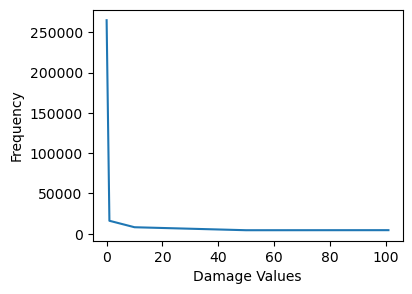

In [7]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(
    join_df["percent_buildings_damaged"], bins=bins2
)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [8]:
# Check the bins' intervalls
join_df["percent_buildings_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    265161
(9e-05, 1.0]        16114
(1.0, 10.0]          8077
(50.0, 101.0]        4424
(10.0, 50.0]         4379
Name: percent_buildings_damaged, dtype: int64

In [9]:
# Remove zeros from wind_speed
join_df = join_df[(join_df[["wind_speed"]] != 0).any(axis=1)]
join_df = join_df.drop(columns=["grid_point_id", "typhoon_year"])
join_df.head()

,typhoon_name,wind_speed,track_distance,total_buildings,percent_buildings_damaged,ADM3_PCODE,ADM3_EN,Centroid,weight
67,DURIAN,13.077471,262.598363,35.0,0.0,PH175312000,El Nido,119.3E_11.2N,0.003593
68,DURIAN,12.511864,273.639330,179.0,0.0,PH175312000,El Nido,119.3E_11.1N,0.018374
69,DURIAN,11.977511,284.680297,44.0,0.0,PH175312000,El Nido,119.3E_11.0N,0.004517
70,DURIAN,11.977511,284.680297,44.0,0.0,PH175320000,Taytay,119.3E_11.0N,0.025407
71,DURIAN,11.471921,295.721263,14.0,0.0,PH175320000,Taytay,119.3E_10.9N,0.009121


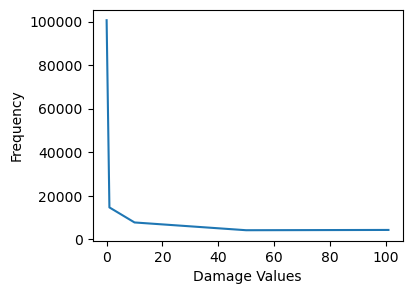

In [10]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(
    join_df["percent_buildings_damaged"], bins=bins2
)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [11]:
print(samples_per_bin2)
print(binsP2)

[100608  14640   7728   4161   4290]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [12]:
# Check the bins' intervalls
join_df["percent_buildings_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    100608
(9e-05, 1.0]        14640
(1.0, 10.0]          7728
(50.0, 101.0]        4290
(10.0, 50.0]         4161
Name: percent_buildings_damaged, dtype: int64

In [13]:
bin_index2 = np.digitize(join_df["percent_buildings_damaged"], bins=binsP2)

In [14]:
y_input_strat = bin_index2

In [15]:
features = [
    "wind_speed",
    # "track_distance",
    # "total_buildings",
]

# Split X and y from dataframe features
X = join_df[features]
display(X.columns)
y = join_df["percent_buildings_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed'], dtype='object')

In [16]:
# Define train-test-split function

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    join_df["percent_buildings_damaged"],
    stratify=y_input_strat,
    test_size=0.2,
)

# Define XGBoost Reduced Overfitting model
xgb = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    colsample_bytree=0.8,
    gamma=3,
    eta=0.01,
    importance_type="gain",
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=4,
    min_child_weight=1,
    missing=1,
    n_estimators=100,
    early_stopping_rounds=10,
    n_jobs=1,
    nthread=None,
    objective="reg:squarederror",
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=0.8,
    verbosity=1,
    eval_metric=["rmse", "logloss"],
    random_state=0,
)

eval_set = [(X_test, y_test)]
xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

[13:23:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                                OLS Regression Results                               
Dep. Variable:     percent_buildings_damaged   R-squared:                       0.210
Model:                                   OLS   Adj. R-squared:                  0.210
Method:                        Least Squares   F-statistic:                 2.790e+04
Date:                       Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                               13:23:28   Log-Likelihood:            -4.3425e+05
No. Observations:                     105141   

In [17]:
# Combine test and training set to have predictiob for all
y_pred_all = xgb.predict(X_scaled)
pred_df = pd.DataFrame(columns=["y_all", "y_pred_all"])
pred_df["y_all"] = join_df["percent_buildings_damaged"]
pred_df["y_pred_all"] = y_pred_all

pred_df

,y_all,y_pred_all
67,0.0,0.591627
68,0.0,0.591627
69,0.0,0.537073
70,0.0,0.537073
71,0.0,0.537073
...,...,...
297690,0.0,0.401472
297691,0.0,0.401472
297692,0.0,0.296275
297744,0.0,0.296275


In [18]:
bin_index = np.digitize(pred_df["y_all"], bins=binsP2)

In [19]:
# Join the below columns with y_all and y_all_pred
filterW = [
    "ADM3_PCODE",
    "typhoon_name",
    "weight",
]
join_df_filterd = join_df[filterW]
join_df_w_pred = pd.merge(pred_df, join_df_filterd, left_index=True, right_index=True)

# Multiply weight by y_all and y_pred_all
join_df_w_pred["weight_y_pred"] = (
    join_df_w_pred["y_pred_all"] * join_df_w_pred["weight"]
)
join_df_w_pred["weight_y"] = join_df_w_pred["y_all"] * join_df_w_pred["weight"]
join_df_w_pred

,y_all,y_pred_all,ADM3_PCODE,typhoon_name,weight,weight_y_pred,weight_y
67,0.0,0.591627,PH175312000,DURIAN,0.003593,0.002126,0.0
68,0.0,0.591627,PH175312000,DURIAN,0.018374,0.010871,0.0
69,0.0,0.537073,PH175312000,DURIAN,0.004517,0.002426,0.0
70,0.0,0.537073,PH175320000,DURIAN,0.025407,0.013646,0.0
71,0.0,0.537073,PH175320000,DURIAN,0.009121,0.004898,0.0
...,...,...,...,...,...,...,...
297690,0.0,0.401472,PH082609000,MOLAVE,0.003752,0.001506,0.0
297691,0.0,0.401472,PH082609000,MOLAVE,0.127330,0.051119,0.0
297692,0.0,0.296275,PH082609000,MOLAVE,0.061327,0.018170,0.0
297744,0.0,0.296275,PH082609000,MOLAVE,0.008243,0.002442,0.0


In [20]:
# Groupby by municipality and typhoon_name with sum as the aggregation function
agg_df = join_df_w_pred.groupby(["ADM3_PCODE", "typhoon_name"]).agg("sum")

# Normalize by the sum of the weights
agg_df["y_pred_norm"] = agg_df["weight_y_pred"] / agg_df["weight"]
agg_df["y_norm"] = agg_df["weight_y"] / agg_df["weight"]

# Drop not required column y and y_pred before multiplying by weight
agg_df.drop("y_all", axis=1, inplace=True)
agg_df.drop("y_pred_all", axis=1, inplace=True)

agg_df

weight  weight_y_pred   weight_y  y_pred_norm  \
ADM3_PCODE  typhoon_name                                                  
PH012801000 BOPHA            1.0       0.613366   0.000000     0.613366   
            FENGSHEN         1.0       0.537073   0.000000     0.537073   
            FUNG-WONG        1.0       0.535575   0.066372     0.535575   
            GONI             1.0       0.535575   0.041482     0.535575   
            HAIMA            1.0      15.216913   0.284845    15.216913   
...                          ...            ...        ...          ...   
PH175917000 PHANFONE         1.0       7.221292  97.495732     7.221292   
            RAMMASUN         1.0       0.769851  95.692224     0.769851   
            TOKAGE           1.0       0.769851   0.250000     0.769851   
            VAMCO            1.0       0.591627   0.000000     0.591627   
            VONGFONG         1.0       0.360465   0.000000     0.360465   

                             y_norm  
ADM3_PCODE  typhoon_name             
PH012801000 BOPHA          0.000000  
            FENGSHEN       0.000000  
            FUNG-WONG      0.066372  
            GONI           0.041482  
            HAIMA          0.284845  
...                             ...  
PH175917000 PHANFONE      97.495732  
            RAMMASUN      95.692224  
            TOKAGE         0.250000  
            VAMCO          0.000000  
            VONGFONG       0.000000  

[25527 rows x 5 columns]

In [21]:
# agg_df.isnull().values.any()

# Remove rows with NaN after normalization
final_df = agg_df.dropna()
final_df

weight  weight_y_pred   weight_y  y_pred_norm  \
ADM3_PCODE  typhoon_name                                                  
PH012801000 BOPHA            1.0       0.613366   0.000000     0.613366   
            FENGSHEN         1.0       0.537073   0.000000     0.537073   
            FUNG-WONG        1.0       0.535575   0.066372     0.535575   
            GONI             1.0       0.535575   0.041482     0.535575   
            HAIMA            1.0      15.216913   0.284845    15.216913   
...                          ...            ...        ...          ...   
PH175917000 PHANFONE         1.0       7.221292  97.495732     7.221292   
            RAMMASUN         1.0       0.769851  95.692224     0.769851   
            TOKAGE           1.0       0.769851   0.250000     0.769851   
            VAMCO            1.0       0.591627   0.000000     0.591627   
            VONGFONG         1.0       0.360465   0.000000     0.360465   

                             y_norm  
ADM3_PCODE  typhoon_name             
PH012801000 BOPHA          0.000000  
            FENGSHEN       0.000000  
            FUNG-WONG      0.066372  
            GONI           0.041482  
            HAIMA          0.284845  
...                             ...  
PH175917000 PHANFONE      97.495732  
            RAMMASUN      95.692224  
            TOKAGE         0.250000  
            VAMCO          0.000000  
            VONGFONG       0.000000  

[25407 rows x 5 columns]

In [22]:
# Calculate RMSE in total for converted grid_based model to Mun_based

rmse = sqrt(mean_squared_error(final_df["y_norm"], final_df["y_pred_norm"]))
print(f"RMSE for grid_based model: {rmse:.2f}")

RMSE for grid_based model: 11.59


In [23]:
bin_index = np.digitize(final_df["y_norm"], bins=binsP2)

### Calculate RMSE per bin for converted grid_based model to Mun_based

In [24]:
# Define a function to estimate RMSE per bin

def rmse_bin(n):
    mse = mean_squared_error(
        final_df["y_norm"][bin_index == n],
        final_df["y_pred_norm"][bin_index == n],
    )
    rmse = np.sqrt(mse)
    print(f"RMSE per bin_{n}: {rmse:.2f}")

for bin_num in range(1, 6):
    rmse_bin(bin_num)

RMSE per bin1: 2.51
RMSE per bin2: 7.30
RMSE per bin3: 10.96
RMSE per bin4: 18.85
RMSE per bin5: 56.61


### Check if y_norm is the the same as the damage ground truth in the original model

In [24]:
# Read the weight CSV file and import to df
df_old_data = pd.read_csv("old_data.csv")
df_old_data.drop("Unnamed: 0", axis=1, inplace=True)
df_old_data.columns = df_old_data.columns.str.replace("Mun_Code", "ADM3_PCODE")
df_old_data.head()

,ADM3_PCODE,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3
0,PH175101000,durian2006,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,...,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548
1,PH083701000,durian2006,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,...,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323
2,PH015501000,durian2006,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,...,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762
3,PH015502000,durian2006,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,...,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328
4,PH175302000,durian2006,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,...,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901


In [25]:
# Capitalize strings typhoon column and change the typhoon column's name
for i in range(len(df_old_data)):
    df_old_data.at[i, "typhoon_name"] = df_old_data.loc[i, "typhoon"].upper()

del df_old_data["typhoon"]
df_old_data

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_name
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,DURIAN2006
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323,DURIAN2006
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762,DURIAN2006
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328,DURIAN2006
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901,DURIAN2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000,538.743551,NOUL2015
8069,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000,946.676507,NOUL2015
8070,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000,3938.254316,NOUL2015
8071,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000,2666.620370,NOUL2015


In [26]:
# Remove year from typhoons' name
for i in range(len(df_old_data)):
    if df_old_data.at[i, "typhoon_name"] == "GONI2015":
        df_old_data.loc[i, "typhoon_name"] = "GONI2015"

    elif df_old_data.at[i, "typhoon_name"] == "GONI2020":
        df_old_data.loc[i, "typhoon_name"] = "GONI2020"

    else:
        df_old_data.loc[i, "typhoon_name"] = df_old_data.loc[i, "typhoon_name"][:-4]


df_old_data

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_name
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,DURIAN
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323,DURIAN
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762,DURIAN
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328,DURIAN
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901,DURIAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000,538.743551,NOUL
8069,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000,946.676507,NOUL
8070,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000,3938.254316,NOUL
8071,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000,2666.620370,NOUL


In [27]:
agg_df_old_data = df_old_data.groupby(["ADM3_PCODE"]).agg("sum")
agg_df_old_data

,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,GEN_Red_per_LSbldg,...,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3
ADM3_PCODE,,,,,,,,,,,,,,,,,,,,,
PH012801000,1540.191667,69.743056,40.703450,267.204204,1137.195510,36.72,0.00,0.00,36.72,36.72,...,2.189781,21.897810,0.000000,0.000000,0.000000,0.000000,22.098214,370.072993,0.973236,713418.086535
PH012802000,1567.800000,66.133333,41.231272,289.548362,1116.545916,14.10,15.40,15.40,14.10,0.00,...,0.647920,4.535441,0.000000,0.129584,0.000000,0.259168,5.370169,83.322535,1.399508,600411.585560
PH012803000,1482.887500,84.754167,44.353513,260.810168,1188.415514,24.50,16.80,16.80,24.50,0.40,...,15.513627,65.408805,0.279525,0.000000,0.000000,0.419287,14.581225,208.106219,7.491265,366336.115659
PH012804000,1714.850000,92.071667,46.335691,341.286734,998.382173,28.80,15.10,15.10,28.80,4.10,...,11.035654,26.032824,1.697793,0.000000,0.000000,0.000000,11.177754,149.405772,1.245048,878159.265616
PH012805000,2049.008333,94.663258,56.398160,287.371061,1908.790607,0.39,0.39,0.39,0.39,0.39,...,4.211208,24.425008,0.210560,0.105280,0.000000,0.000000,7.865800,178.660512,0.688371,419859.619693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PH175913000,369.121429,32.132143,13.755053,61.168774,155.821370,7.08,4.22,4.22,7.08,3.16,...,7.673765,67.657694,0.281237,0.361591,1.084773,0.160707,6.016072,62.394536,1.004419,61326.291421
PH175914000,97.650000,5.802273,3.454654,82.724509,705.502314,0.00,0.00,0.00,0.00,0.00,...,30.447512,156.085320,0.501882,0.000000,0.000000,0.167294,16.101461,137.348390,3.429527,87982.096558
PH175915000,265.100000,14.297424,8.030009,94.082701,879.185712,0.00,0.00,0.00,0.00,0.00,...,40.503928,240.314278,0.135465,0.000000,0.000000,0.000000,21.990309,173.530209,2.898943,64533.566739


In [28]:
df_merged = df_old_data.merge(
    agg_df["y_norm"], how="left", on=["ADM3_PCODE", "typhoon_name"]
)

df_merged

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_name,y_norm
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,DURIAN,4.54049
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323,DURIAN,0.00000
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762,DURIAN,0.00000
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328,DURIAN,0.00000
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901,DURIAN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000,538.743551,NOUL,0.00000
8069,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000,946.676507,NOUL,NaN
8070,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000,3938.254316,NOUL,0.00000
8071,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000,2666.620370,NOUL,0.00000


In [31]:
# df_merged.isnull().sum()
df_merged_2 = df_merged.dropna()

In [32]:
df_merged_2.reset_index(drop=True, inplace=True)
df_merged_2

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_name,y_norm
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,DURIAN,4.540490
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323,DURIAN,0.000000
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762,DURIAN,0.000000
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328,DURIAN,0.000000
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901,DURIAN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7627,PH020906000,160.700000,18.266667,6.759574,54.379415,13.322384,9.05,0.90,0.90,9.05,...,0.000000,0.000000,0.000000,0.000000,0.771010,16.384181,1.129944,160806.495664,NOUL,0.327048
7628,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000,538.743551,NOUL,0.000000
7629,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000,3938.254316,NOUL,0.000000
7630,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000,2666.620370,NOUL,0.000000


In [33]:
for i in range(len(df_merged_2)):
    if df_merged_2.loc[i, "DAM_perc_dmg"] == df_merged_2.loc[i, "y_norm"]:
        df_merged_2.at[i, "compare"] = "True"
    elif df_merged_2.loc[i, "DAM_perc_dmg"] != df_merged_2.loc[i, "y_norm"]:
        df_merged_2.at[i, "compare"] = "False"


df_merged_2

/var/folders/sx/c10hm4fj3glf7mw1_mzwcl700000gn/T/ipykernel_8524/1146880797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_2.at[i, "compare"] = "False"


,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_name,y_norm,compare
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,DURIAN,4.540490,False
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323,DURIAN,0.000000,True
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762,DURIAN,0.000000,True
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328,DURIAN,0.000000,True
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901,DURIAN,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7627,PH020906000,160.700000,18.266667,6.759574,54.379415,13.322384,9.05,0.90,0.90,9.05,...,0.000000,0.000000,0.000000,0.771010,16.384181,1.129944,160806.495664,NOUL,0.327048,False
7628,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000,538.743551,NOUL,0.000000,True
7629,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000,3938.254316,NOUL,0.000000,True
7630,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000,2666.620370,NOUL,0.000000,True


In [34]:
# df_merged_2["compare"].value_counts()

In [35]:
df_merged_2 = df_merged_2[~df_merged_2.select_dtypes(["object"]).eq("True").any(1)]
df_merged_2

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_name,y_norm,compare
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,DURIAN,4.540490,False
6,PH043401000,137.825000,11.141667,5.282292,45.946435,58.003453,0.00,0.00,0.00,0.00,...,0.018141,0.036281,0.199546,0.470131,6.820862,0.272109,96996.365877,DURIAN,0.755972,False
15,PH035403000,34.700000,2.976389,1.373264,17.959482,180.568781,0.00,0.00,0.00,0.00,...,0.065614,0.266103,0.156746,1.313187,12.659935,0.000000,5792.704695,DURIAN,0.000933,False
16,PH054101000,153.995000,14.470833,6.238125,23.682962,103.825021,3.10,3.37,3.37,3.10,...,0.000000,0.093902,0.023476,1.983335,35.007923,0.011738,13283.363247,DURIAN,0.052385,False
18,PH045603000,184.885714,12.269048,6.526786,48.395610,47.016707,2.98,3.48,3.48,2.98,...,0.055471,0.152545,0.159479,1.114579,13.992511,0.000000,113349.056134,DURIAN,0.007717,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7292,PH020906000,297.450000,20.550000,11.245833,60.682289,36.716509,9.05,0.90,0.90,9.05,...,0.000000,0.000000,0.000000,0.771010,16.384181,1.412429,223452.827181,MERANTI,9.630007,False
7425,PH020903000,169.225000,18.904167,7.112766,54.379415,13.322384,10.98,0.00,0.00,10.90,...,0.000000,0.000000,0.000000,0.226074,16.246499,0.000000,160806.495664,NOUL,0.105875,False
7579,PH021523000,113.950000,9.426852,4.442080,63.460137,9.357787,1.44,18.88,18.80,1.44,...,0.025897,0.116535,0.090638,1.154805,13.259096,0.634468,255565.964794,NOUL,0.485341,False
7589,PH021525000,84.687500,6.039583,3.543085,38.632415,54.779271,2.31,15.20,15.20,2.31,...,0.070061,0.046707,0.046707,1.187099,11.560019,0.070061,57657.470633,NOUL,0.050870,False


In [36]:
print(df_merged_2["DAM_perc_dmg"].corr(df_merged_2["y_norm"]))

0.5399475448978028


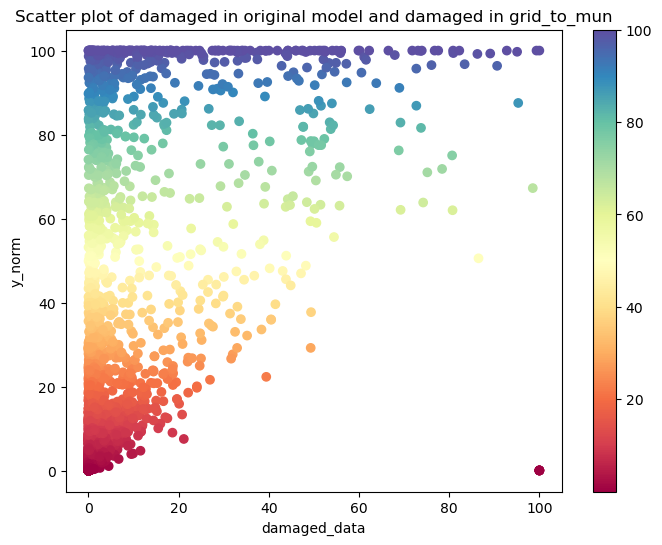

In [37]:
x = df_merged_2["DAM_perc_dmg"]
y = df_merged_2["y_norm"]
plt.rcParams.update({"figure.figsize": (8, 6), "figure.dpi": 100})
plt.scatter(x, y, c=y, cmap="Spectral")
plt.colorbar()
plt.title("Scatter plot of damaged in original model and damaged in grid_to_mun")
plt.xlabel("damaged_data")
plt.ylabel("y_norm")
plt.show()

Text(0, 0.5, 'Frequency')

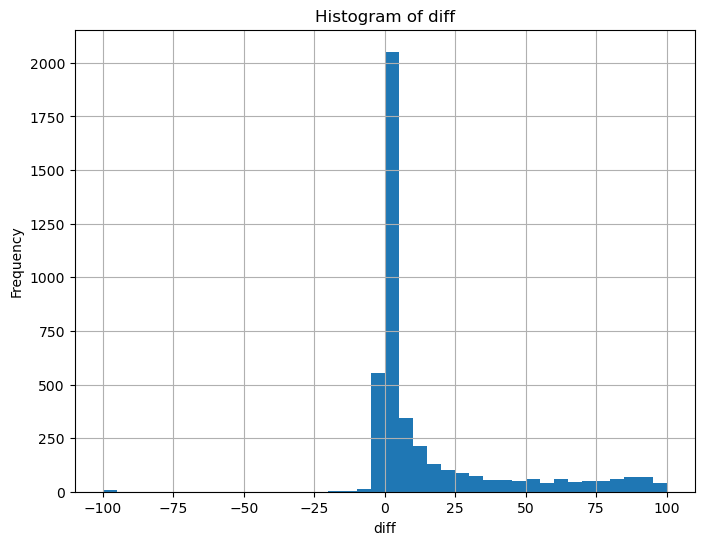

In [38]:
diff = df_merged_2["y_norm"] - df_merged_2["DAM_perc_dmg"]
diff.hist(bins=40, figsize=(8, 6))
plt.title("Histogram of diff")
plt.xlabel("diff")
plt.ylabel("Frequency")